# Emotion Propagation in Online Social Networks
##### Code Workflow
This is the framework code for the '*Emotion Propagation in Online Social Networks*' project. <br>
You can find the associated paper here.

## Data Collection and Pre-Processing

### Setup

#### Imports

In [2]:
# Custom modules path
import sys; sys.path.append('./libraries')
import warnings; warnings.filterwarnings('ignore')
# Custom modules
from utils import *
# Basic libraries
import pandas as pd
import numpy as np
from collections import Counter
from datetime import timedelta
import re
# Network libraries
import networkx as nx
from scipy.sparse import csgraph
import network_distance as nd
# Statistic libraries
from scipy.stats import entropy, pearsonr, spearmanr, ks_2samp, kruskal, tukey_hsd
# NLP libraries
import tweetnlp
from nltk.corpus import stopwords
# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

#### Filepaths & Constants

Relative paths to the repository.

In [3]:
root = '../data/'
raw_path = root + '0- Raw collected data/'
processed_path = root + '1- Processed data/'
finetuning_path = root + '2- NLP/1- Fine Tuning'
emotions_path = root + '2- NLP/2- Emotions/'
propagation_path = root + '3- Propagation/'

Switches to process data from scratch, or load the processed data. <br>
For looking at results, suffices to set all switches to False. <br>
For corroboration of the steps, suffices to set the relevant switches to True. <br>
For complete replication of the results from the raw collected data, set everything to True. NOTE: We do not recommend this, since the classification process takes a very long time. We therefore recommend running the classification in a High Perfomance Cluster.

In [4]:
# SWITCHES : 
process = False                 # To process everything from Raw Data or load Processed Data
classify = False                 # To classify and extract tweets emotions or load Classified Data
propagate = False                # To calculate propagation or load Propagation Data
access_to_all = False

A few variable settings.

In [5]:
# SETTINGS
# Set of Networks
networks = {
    "us_congressmen": {}, 
    "journalists": {}, 
    "universities": {}
    }

# Set of emotions (and their associated color)
emotions = {
    "joy": "gold",
    "optimism": "lawngreen",
    "anger": "crimson",
    "sadness": "mediumslateblue"
    }

# Set of Datasets collected
datasets = ["user_info", "tweets", "follows"]

### Load raw data

Data was collected using [Twitter Lists](https://help.twitter.com/en/using-twitter/twitter-lists). This allowed us to collect data on specific users from a determined "community". The collected "Twitter Communities" are from three different domains:
- US Congressmen: Current and former (previous period) US Congressmen (Senators and Representatives);
- Journalists:  Journalists and staff from Wall Street Journal, NY Times, NY Post, Washington Post and LA Times;
- Universities: Researchers and staff from Cambridge University, NY University and Princeton University  

For each of those communities, three datasets were collected:
- User Info: includes Twitter User ID, Display Name, Username (handle), Public Metrics, etc;
- Tweets: includes tweets for the period Jan-2022 to Feb-2023 for each user
- Follows: the list of people following by each of the users in User Info. This is used to construct the network

We'll organize our networks in a dictionary containing each dataset.

In [6]:
if access_to_all:
    print(">>> LOADED DATA <<<")
    for net in networks:

        if not process:
            # We don't save 'follows' as processed
            datasets = datasets[:2]
            path = processed_path

        else:
            # If we process everything from raw
            path = raw_path + f"{net}/"

        for ds in datasets:

            networks[net][ds] = pd.read_csv(path + f"DF-{net}-{ds}.csv", encoding="utf-8", dtype={"id": str, "author_id": str, "mainUserID": str, 
                                                "retweeted": str, "possibly_sensitive": str})

            # Filter only tweets from before 23/12
            if ds == "tweets":
                # We need to convert to Datetime format to truncate miliseconds
                networks[net][ds].loc[:,"created_at"] = pd.to_datetime(networks[net][ds].created_at, format="%Y-%m-%d %H:%M:%S")

            print(f"{'RAW' if process else 'PROCESSED'} DATA // Network: {net} - {ds} - Shape: {networks[net][ds].shape}")

### Pre-Process Tweets

#### Replace Retweets' text by original text
By default, when a Tweet is a Retweet, Twitter appends the prefix RT and shortens the text (possibly to save space). Nevertheless, the id of the original tweet is also returned. From this ID we restore the original text of the tweet and replace the shorten version by the original one.

In [7]:
if process and access_to_all:
    
    for net in networks:

        # Read auxiliary retweet data and rename columns to match Tweets DF
        aux_rt = pd.read_csv(raw_path + f"{net}/DF-{net}-aux_retweets.csv", encoding="utf-8", dtype={"id": str})
        aux_rt.columns = ["retweeted", "text"]

        # Split Tweets DF in original tweets and retweets
        originals = networks[net]["tweets"][networks[net]["tweets"].retweeted.isna()]
        retweets = networks[net]["tweets"][~networks[net]["tweets"].retweeted.isna()]

        # Merge the retweets with the aux data to get the complete text
        retweets = retweets.merge(aux_rt, on= "retweeted", how="inner") # If inner, we are discarding RT that haven't been found

        # Replace the RT shorten text for the original text, drop aux col, and rename back to 'text'
        retweets["text_x"] = retweets.text_y
        retweets.drop("text_y", axis=1, inplace=True)
        retweets.rename(columns={'text_x':'text'}, inplace=True)

        # Put back together the Tweets Dataset
        networks[net]["tweets"] = pd.concat([originals, retweets])
        networks[net]["tweets"].sort_index(inplace=True, ignore_index=True)

#### Filter Tweets

The data-cleaning process of the tweets include:
- Filter out non-English tweets: The NLP model used is trained only on English tweets, to preserve the quality of the analysis;
- Remove mentions: Mentions in Tweets are removed, to reduce noise in the text;
- Remove URLs: URLs are also removed, for the same reasons as above;
- Remove undefined characters: Some tweets contain undefined non-parsed characters that were removed to preserve the quality of the data


In [8]:
if process and access_to_all:
    
    for net in networks:

        # Filter out non-English tweets
        networks[net]["tweets"] = tweetFilter(networks[net]["tweets"])

### Prepare Network

Check overall yearly activity for different window sizes, using the raw data. Create Figure 1.

In [9]:
if process and access_to_all:

    # Style
    windows = {
        3: ["dotted", "."],
        7: ["dashed", "^"],
        10: ["solid", "o"]
    }
    
    # Check for different window sizes
    for w in windows:
        
        # Calculate active users
        for net in networks:

            # We need to check if the window will leave the last gap unfinished
            temp = networks[net]["tweets"].loc[:,["created_at", "author_id"]].groupby(pd.Grouper(key="created_at", freq=f"{w}d")).nunique("author_id").reset_index()
            if ((networks[net]["tweets"].created_at.max() - pd.to_datetime("2022-01-01", format="%Y-%m-%d %H:%M:%S")).days + 1) % w > 0:
                temp = temp.iloc[:-1]
            temp["author_id"] = temp["author_id"] / networks[net]["tweets"].author_id.nunique() * 100
            sns.set(rc={'figure.figsize':(16,4)})
            sns.set_style("ticks")
            sns.lineplot(temp, x="created_at", y="author_id", linestyle=windows[w][0], marker=windows[w][1])
            sns.despine()
            plt.grid(axis='both', color='grey', linestyle='dashed', linewidth=0.5)
            plt.xlabel("")
            plt.ylabel("")
            plt.ylim(20,100)
        plt.show()

Check activity (number of tweets) per weekday. Create Figure 3

In [10]:
if process and access_to_all:

    # For each network
    for net in networks:

        print(f"Network: {net.upper()}")
        # Use a copy of the tweets dataset
        temp = networks[net]["tweets"].copy()
        temp["created_at"] = pd.to_datetime(temp["created_at"])
        # Extract the weekday number and name for the dates
        temp["#"] = temp["created_at"].apply(lambda x: x.weekday())
        temp["Day of Week"] = temp["created_at"].apply(lambda x: x.day_name())

        # Calculate the number of tweets posted per day of the week
        day_activity = temp.groupby(["#", "Day of Week"]).size().reset_index()
        day_activity.columns = ["#", "Week Day", "Activity"]
        # Calculate the percentage of activity
        day_activity["%"] = round(day_activity.Activity / day_activity.Activity.sum() * 100,2)

        # Plot settings
        sns.set(rc={'figure.figsize':(16,4)})
        sns.set_style("ticks")
        sns.lineplot(day_activity, x="Week Day", y="%", palette=["blue", "orange", "green"], marker="s")
        sns.despine()
        plt.grid(axis='y', color='grey', linestyle='dashed', linewidth=0.5)
        plt.xlabel("Weekday")
        plt.ylabel("% Activity")

#### Remove users with large inactivity

We want to remove those users that are not active enough to be considered in the experiment. For this, a baseline threshold is defined:
* Window: 7 days. To be considered active, we'll evaluate the amount of tweets the user has in a period of seven days.
* Activity Threshold: 4 tweets. In the period of 7 days, the user needs to have tweeted at least 4 times.
* Max Gap: 1. If the user doesn't reach this minimum activity threshold in one given week, the "expressed emotion" can be interpolated. If the user violates this minimum activity baseline for 2 or more consecutive weeks, then the user is removed from the experiment.

##### Parameters. Change these to see results in Figure 2

In [11]:
# Define parameters to consider minimum activity of users
window = "7d"               #-> The window for considering the emotional status of a node
activity_threshold = 4      #-> The minimum number of tweets an user needs to be considered "active" during the time window
max_gap = 1                 #-> The maximum consecutive gap allowed for users to be "inactive"

In [12]:
if process and access_to_all:
    
    for net in networks:

        # We need to convert to Datetime format to truncate miliseconds
        networks[net]["tweets"].created_at = pd.to_datetime(networks[net]["tweets"].created_at, format="%Y-%m-%d %H:%M:%S")

        # Get subset of active users
        act_urs = getActiveUsers(networks[net]["tweets"], window, max_gap, activity_threshold)
        networks[net]["user_info"] = networks[net]["user_info"].loc[networks[net]["user_info"].id.isin(act_urs)]
        networks[net]["follows"] = networks[net]["follows"].loc[networks[net]["follows"].mainUserID.isin(act_urs)]

#### Create Network

- Remove users not following each other
- Remove nodes not in largest component
- Compute edge weights
- Create edgelist and graph

In [22]:
# For each network
for net in networks:
    
    if process and access_to_all:

            # Use edgeListMaker to create the Edgelist from users following each other
            edgelist = edgeListMaker(networks[net]["user_info"], networks[net]["follows"], networks[net]["tweets"], save_edgelist=True, \
            edgelist_path=processed_path + f"EDGELIST-{net}-undirected.csv")
            networks[net]["edgelist"] = edgelist
            # We create the Graph from the Edgelist
            G = nx.from_pandas_edgelist(edgelist)
            networks[net]["graph"] = G

            # We identify the nodes to reduce the datasets to only those nodes, and store them
            nodes = list(G.nodes())
            networks[net]["user_info"] = networks[net]["user_info"].loc[networks[net]["user_info"].id.isin(nodes)]
            networks[net]["follows"] = networks[net]["follows"].loc[networks[net]["follows"].mainUserID.isin(nodes)]
            networks[net]["tweets"] = networks[net]["tweets"].loc[networks[net]["tweets"].author_id.isin(nodes)]
        
    # Else read from processed data
    else:
        networks[net]["graph"] = nx.read_edgelist(processed_path + f"EDGELIST-{net}-undirected.csv", comments="source", delimiter=",", data=(("weight", float),), encoding='utf-8')

Force all members of US Congress to adopt a bipartisan disposition

In [14]:
if access_to_all:
    networks["us_congressmen"]["user_info"].loc[networks["us_congressmen"]["user_info"]["party"] != "Republican", "party"] = "Democratic"

#### Save reduced process datasets

In [23]:
if process and access_to_all:

    for net in networks:

        ## TWEETS ##
        # We only need these columns
        keep_cols = ["author_id", "id", "text", "created_at", "retweeted"]
        # We only need to know if the tweet is a retweet (transform to bool to save space)
        networks[net]["tweets"]["retweeted"] = networks[net]["tweets"]["retweeted"].apply(lambda x: False if type(x) != str else True)
        networks[net]["tweets"] = networks[net]["tweets"][keep_cols]
        # Save to Processed Data
        networks[net]["tweets"].to_csv(processed_path + f"DF-{net}-tweets.csv", encoding="utf-8", index=False)

        ## USER INFO ##
        networks[net]["user_info"].drop(["created_at", "protected", "verified", "followers_count", "following_count", "listed_count"], axis=1, inplace=True)
        # Save to Processed Data
        networks[net]["user_info"].to_csv(processed_path + f"DF-{net}-user_info.csv", encoding="utf-8", index=False)

#### Show Networks basic properties seen in Table 13

In [25]:
# Partition for different networks
partition = {
    "us_congressmen": "party",
    "journalists": "newspaper",
    "universities": "university"
    }
if access_to_all:
    for net in networks:
        print(f"Network -> {net}")
        # Extract list of nodes
        nodes = list(networks[net]["graph"].nodes())
        communities = []
        # Construct the set of communities given their respective partition
        for p in networks[net]["user_info"][partition[net]].unique():
            # Nodes for a given partition of the network
            p_nodes = networks[net]["user_info"].loc[(networks[net]["user_info"][partition[net]] == p) & (networks[net]["user_info"]["id"].isin(nodes))].id
            # Append the partition set to the list of partitions
            communities.append(set(p_nodes))

        GraphProperties(networks[net]["graph"], communities=communities)

## Emotion Recognition

### Fine Tuning

The chosen NLP model to extract the emotion from tweets is [TweetNLP](https://tweetnlp.org/), a roBERTa-base model trained on tweets, and further fine-tuned for the task of emotion extraction. 

In [17]:
# Let's load the TweetNLP Training set
dataset, label_to_id = tweetnlp.load_dataset("emotion")

Reusing dataset tweet_eval (C:\Users\jonsy\.cache\huggingface\datasets\tweet_eval\emotion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

#### Label distributions

For train set in TweetNLP Baseline fine tuning:

In [18]:
# Let's look the label distribution
total = len(dataset['train']['label'])
print(f"Total training samples: {total}\n")
print("Training dataset label distribution:\n")

for label, i in label_to_id.items():
    nr = len([x for x in dataset["train"]["label"] if x == i])
    print(f"{label.upper()}: {nr} ({nr/total:.2%})")

Total training samples: 3257

Training dataset label distribution:

ANGER: 1400 (42.98%)
JOY: 708 (21.74%)
OPTIMISM: 294 (9.03%)
SADNESS: 855 (26.25%)


For annotation samples:

In [19]:
if access_to_all:
    # Let's load our annotations
    samples, labels = load_annotations(finetuning_path + '/annotations/')

    # Let's look the label distribution for our annotations
    total = len(labels)
    print(f"Total annotated samples: {total}\n")
    print("Annotated dataset label distribution:\n")

    for label in ["undefined"] + list(label_to_id.keys()):
        nr = len([x for x in labels if x == label])
        print(f"{label.upper()}: {nr} ({nr/total:.2%})")

Label distribution of samples used in fine tuning process:

In [20]:
if access_to_all:
    # Let's look the label distribution for our custom fine tuning
    train = pd.read_csv(finetuning_path + '/all/train.csv', encoding="utf-8")
    total = train.shape[0]
    print(f"Total training samples: {total}\n")
    print("Training dataset label distribution:\n")

    for label, i in label_to_id.items():
        nr = train[train.label == i].shape[0]
        print(f"{label.upper()}: {nr} ({nr/total:.2%})")

#### Classify using Fine Tuned TweetNLP

Given the large amount of tweets to classify (2.060.983), this stage was performed in ITU's High Performance Cluster for approximately 206 hs. <br>
The example set up follows here:

In [26]:
if classify and access_to_all:
    
    # Load Finetuned model
    model = tweetnlp.load_model('emotion', model_name="./nlp_model/models/all")

    # Set a batch size according to resources
    batch_size = 10000

    # Classify tweets for each network
    for net in networks:
    
        # We need to split tweet dataset in batches
        classified_samples = []

        # Read tweet dataset
        tweets = pd.read_csv(f"./data/1- Processed data/DF-{net}-tweets.csv", encoding="utf-8")

        # Get number of batches needed
        batches =  tweets.shape[0] // batch_size + 1

        # Predict by batches
        for batch in range(0, batches):

            # If it's the last batch, slice to the end
            if batch == batches-1:
                tweets_subset = tweets.iloc[(batch*batch_size):]

            # Otherwise slice to the batch
            else:
                tweets_subset = tweets.iloc[batch*batch_size:(batch*batch_size)+batch_size]

            # Predict on text
            result = model.predict(tweets_subset.text, return_probability = True)
            result = pd.DataFrame(result)

            # Extract the predictions and calculate the entropy
            joy = []
            optimism = []
            anger = []
            sadness = []

            for ix, row in result.iterrows():
                joy.append(row["probability"]["joy"])
                optimism.append(row["probability"]["optimism"])
                anger.append(row["probability"]["anger"])
                sadness.append(row["probability"]["sadness"])

            result["joy"] = joy
            result["optimism"] = optimism
            result["anger"] = anger
            result["sadness"] = sadness
            result.drop("probability", axis=1, inplace=True)
            result["nEntropy"] = result[["joy", "optimism", "anger", "sadness"]].apply(entropy, axis=1)
            result["nEntropy"] = result.nEntropy / (np.log(4))

            # Append the batch results
            classified_samples.append(result)

        # Concat all results in one DF
        classified_samples = pd.concat(classified_samples)

        # Keep only User ID, Creation Date and Classification results
        classified_samples = classified_samples[["author_id", "created_at", "retweeted", "joy", "optimism", "anger", "sadness", "nEntropy"]]

        # Save to file
        classified_samples.to_csv(f"{emotions_path}{net}-emotions.csv", encoding="utf-8", index=False)

We can now load the classified emotions per tweet, user and date.

In [27]:
for net in networks:

    networks[net]["emotions"] = pd.read_csv(f"{emotions_path}{net}-tweets-emotions.csv", encoding="utf-8", dtype={"author_id": str})

### Transform uncertain predictions into undefined, aggregate emotions and interpolate missing emotions in gaps

##### First, let's look at the proportion of labeled samples given our entropy cutoff

In [28]:
# Decided entropy cutoff
entropy_cutoff = 0.07596

print(f"With entropy cutoff at {entropy_cutoff}")
for net in networks:
    #np.percentile(networks[net]["emotions"].nEntropy, np.linspace(0,100,11))
    prop = networks[net]["emotions"][networks[net]["emotions"].nEntropy <= entropy_cutoff].shape[0] /networks[net]["emotions"].shape[0]
    print(f"Network {net}: we keep {prop:.2%} labeled")

With entropy cutoff at 0.07596
Network us_congressmen: we keep 61.72% labeled
Network journalists: we keep 56.96% labeled
Network universities: we keep 61.13% labeled


In [29]:
for net in networks:

    # Scrap values from undefined emotions, given an entropy threashold
    networks[net]["emotions-undefined"] = undefine(networks[net]["emotions"], entropy = entropy_cutoff)

    # Remove noise from low probabilities
    networks[net]["emotions-undefined"] = remove_noise(networks[net]["emotions-undefined"])

    # Aggregate the emotions by week
    networks[net]["emotions-aggregated"] = find_weekly_values(networks[net]["emotions-undefined"])
    networks[net]["emotions-aggregated"].rename(columns={"agg_optimism": "optimism", "agg_joy": "joy", "agg_anger": "anger", "agg_sadness": "sadness"}, inplace=True)

    # Interpolate the gaps
    dfs = []
    for author in networks[net]["emotions-aggregated"].author_id.unique():

        df = networks[net]["emotions-aggregated"].loc[networks[net]["emotions-aggregated"].author_id == author]
        df = interpolate_values(df, activity_threshold = activity_threshold, emotion_idx = [2,3,4,5], act_idx = 6)
        dfs.append(df)

    networks[net]["emotions-interpolated"] = pd.concat(dfs)

#### Testing for interpolation accuracy
To ensure that the interpolation process has not changed the nature of the data, we compute a few statistics:
- Compare average emotion fluctuationa between time steps for all users in all networks
- Evaluate if the distributions are different with a KS test
- Calculate MAE, RMSE and R2 for data before and after interpolation

In [30]:
# Check the emotion fluctuation between timesteps for all users
before_avg = []
after_avg = []

for net in networks:

    print(f"{net.upper()}")

    # Keep only continuos week rows
    continous = networks[net]["emotions-aggregated"][networks[net]["emotions-aggregated"]["weekly_tweet_values"] >= 4]
    # Calculate the gap to ensure we only keep continuos weeks
    continous["gap"] = continous.week.diff().fillna(1)
    continous = continous[continous.gap < 2]

    # For each emotion column
    for e in emotions:

        # We extract the emotion vector before and after interpolation
        original_data = networks[net]["emotions-aggregated"][e]
        interpolated_data = networks[net]["emotions-interpolated"][e]

        # We calculate the critical value for the KS test
        critical_value = 1.358 / (len(original_data) + len(interpolated_data))**0.5  # for alpha = 0.05
        print(f"{e.capitalize()} (critical value: {critical_value:.3f})") 

        # Perform KS test
        stat, p_value = ks_2samp(original_data, interpolated_data)

        # Calculate metrics on dataset difference 
        # Mean Absolute Error (MAE)
        mae = np.mean(np.abs(interpolated_data - original_data))
        # Root Mean Squared Error (RMSE)
        rmse = np.sqrt(np.mean((interpolated_data - original_data) ** 2))
        # Coefficient of Determination (R-squared)
        total_variation = np.sum((original_data - np.mean(original_data)) ** 2)
        residual_variation = np.sum((interpolated_data - original_data) ** 2)
        r_squared = 1 - (residual_variation / total_variation)

        # compare p-value to significance level (e.g., 0.05)
        if stat > critical_value:
            print(f"SAME DISTRIBUTION (stat: {stat:.3f} - p-value: {p_value:.3f})")
        else:
            print(f"DIFFERENT DISTRIBUTION (stat: {stat:.3f} - p-value: {p_value:.3f})")

        print(f"Mean Absolute Error: {mae:.3f}")
        print(f"Root Mean Squared Error: {rmse:.3f}")
        print(f"R-squared: {r_squared:.3f}")
    
        # For each author separately
        for a in continous.author_id.unique():
            # Calculate the fluctuation before and after interpolation
            before_interpolation = continous.loc[continous.author_id == a, e].diff().fillna(0)
            after_interpolation = networks[net]["emotions-interpolated"].loc[networks[net]["emotions-interpolated"].author_id == a, e].diff().fillna(0)
            # Calculate their emotion fluctuation
            before_avg.append(sum(abs(before_interpolation)) / before_interpolation.shape[0])
            after_avg.append(sum(abs(after_interpolation)) / after_interpolation.shape[0])

print(f"Before interpolation, the avg. fluctuation for all users in all networks is {np.mean(before_avg):.5f}")
print(f"After interpolation, the avg. fluctuation for all users in all networks is {np.mean(after_avg):.5f}")

US_CONGRESSMEN
Joy (critical value: 0.007)
SAME DISTRIBUTION (stat: 0.008 - p-value: 0.685)
Mean Absolute Error: 0.002
Root Mean Squared Error: 0.025
R-squared: 0.978
Optimism (critical value: 0.007)
SAME DISTRIBUTION (stat: 0.011 - p-value: 0.214)
Mean Absolute Error: 0.001
Root Mean Squared Error: 0.011
R-squared: 0.989
Anger (critical value: 0.007)
SAME DISTRIBUTION (stat: 0.009 - p-value: 0.439)
Mean Absolute Error: 0.001
Root Mean Squared Error: 0.015
R-squared: 0.992
Sadness (critical value: 0.007)
SAME DISTRIBUTION (stat: 0.013 - p-value: 0.123)
Mean Absolute Error: 0.002
Root Mean Squared Error: 0.019
R-squared: 0.965
JOURNALISTS
Joy (critical value: 0.007)
SAME DISTRIBUTION (stat: 0.016 - p-value: 0.008)
Mean Absolute Error: 0.005
Root Mean Squared Error: 0.036
R-squared: 0.959
Optimism (critical value: 0.007)
SAME DISTRIBUTION (stat: 0.018 - p-value: 0.002)
Mean Absolute Error: 0.001
Root Mean Squared Error: 0.012
R-squared: 0.937
Anger (critical value: 0.007)
SAME DISTRIBUTI

## Emotion Presence in the Networks

##### Boxplots

US_CONGRESSMEN


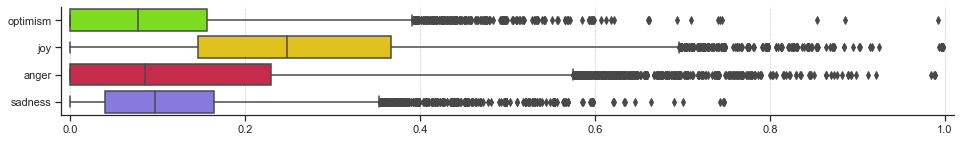

JOURNALISTS


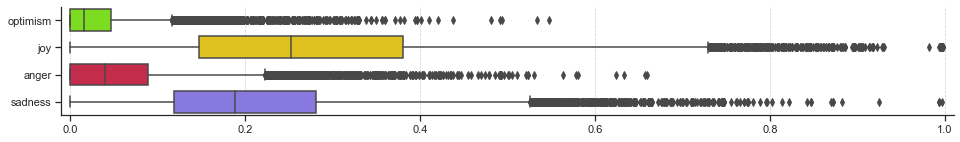

UNIVERSITIES


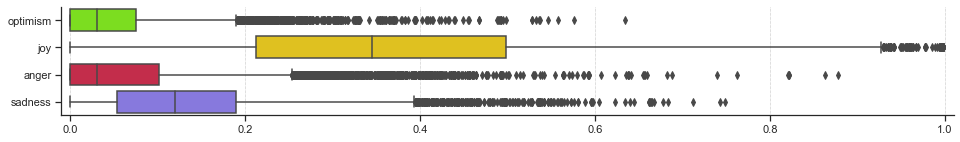

In [55]:
# For each network
for net in networks:

    print(net.upper())

    # Melt emotion columns to show boxplots
    temp = networks[net]["emotions-interpolated"].melt(value_vars=["optimism", "joy", "anger", "sadness"])

    # Plot settings
    sns.set(rc={'figure.figsize':(16,2)})
    sns.set_style("ticks")
    sns.boxplot(data = temp, y="variable", x="value", palette=emotions)
    plt.xlim(-0.01,1.01)
    plt.xlabel("")
    plt.ylabel("")
    plt.grid(axis="x", linestyle="dotted", color="grey", linewidth=0.5)
    sns.despine()
    plt.show()

##### Emotion presence avg, std, and quartiles

In [32]:
for net in networks:
    print(f"NETWORK {net.upper()}")
    temp = networks[net]["emotions-interpolated"][emotions].describe()
    temp.drop("count", inplace=True)
    display(temp.T)

NETWORK US_CONGRESSMEN


,mean,std,min,25%,50%,75%,max
joy,0.268227,0.163540,0.0,0.147127,0.248792,0.366769,0.997549
optimism,0.100331,0.103136,0.0,0.000000,0.077482,0.156847,0.992196
anger,0.145175,0.168822,0.0,0.000000,0.085842,0.229812,0.989060
sadness,0.112209,0.097491,0.0,0.039800,0.097244,0.165313,0.747949


NETWORK JOURNALISTS


,mean,std,min,25%,50%,75%,max
joy,0.277980,0.173228,0.0,0.147706,0.252620,0.380575,0.997487
optimism,0.031868,0.046541,0.0,0.000000,0.016065,0.046683,0.547455
anger,0.058891,0.070173,0.0,0.000000,0.040036,0.089313,0.659792
sadness,0.209521,0.131010,0.0,0.118795,0.189171,0.281666,0.996091


NETWORK UNIVERSITIES


,mean,std,min,25%,50%,75%,max
joy,0.372605,0.208476,0.0,0.212282,0.345432,0.498667,0.997707
optimism,0.051746,0.066687,0.0,0.000000,0.031180,0.076163,0.634541
anger,0.068508,0.096989,0.0,0.000000,0.031513,0.101461,0.877292
sadness,0.132302,0.105095,0.0,0.053606,0.120854,0.189842,0.748104


#### Testing for significant differences between emotion presence in the networks
Using Kruskal-Wallis as the data is not sutable for ANOVA

In [33]:
for net in networks:
    print(f"Network {net.upper()}")
    for e in emotions:
        stat, p_value = kruskal(*[networks[net]['emotions-interpolated'][e] for net in networks])
        print(f"Emotion {e.capitalize()} - P-Value: {p_value} - {p_value / (0.05 * 4)}")

Network US_CONGRESSMEN
Emotion Joy - P-Value: 0.0 - 0.0
Emotion Optimism - P-Value: 0.0 - 0.0
Emotion Anger - P-Value: 0.0 - 0.0
Emotion Sadness - P-Value: 0.0 - 0.0
Network JOURNALISTS
Emotion Joy - P-Value: 0.0 - 0.0
Emotion Optimism - P-Value: 0.0 - 0.0
Emotion Anger - P-Value: 0.0 - 0.0
Emotion Sadness - P-Value: 0.0 - 0.0
Network UNIVERSITIES
Emotion Joy - P-Value: 0.0 - 0.0
Emotion Optimism - P-Value: 0.0 - 0.0
Emotion Anger - P-Value: 0.0 - 0.0
Emotion Sadness - P-Value: 0.0 - 0.0


### Looking at emotion presence per network sub-groups

In [34]:
if access_to_all:
    # Since the groups in each network are called something different, they are coded seperatly
    networks['us_congressmen']['Group'] = (networks['us_congressmen']['emotions-interpolated'].join(
        networks['us_congressmen']['user_info'][['id', 'party']].set_index('id'), on = 'author_id').rename(columns = {'party' : 'Group'}))

    networks['journalists']['Group'] = (networks['journalists']['emotions-interpolated'].join(
        networks['journalists']['user_info'][['id', 'newspaper']].set_index('id'), on = 'author_id').rename(columns = {'newspaper' : 'Group'}))

    networks['universities']['Group'] = (networks['universities']['emotions-interpolated'].join(
        networks['universities']['user_info'][['id', 'university']].set_index('id'), on = 'author_id').rename(columns = {'university' : 'Group'}))

    for net in networks:
        networks[net]['sub_group'] = pd.melt(networks[net]['Group'].groupby(['week', 'Group']).mean().reset_index(),
            id_vars=['week', 'Group'], value_vars=["optimism", "joy", "anger", "sadness"])

    for net in networks:
        networks[net]['group_dict'] = {}
        for group in networks[net]['sub_group']['Group']:
            networks[net]['group_dict'][group] = networks[net]['Group'].author_id[networks[net]['Group'].Group == group]
        networks[net].pop("Group")
        networks[net].pop("group_dict")

#### Plots Figure 17

In [35]:
if access_to_all:
    sns.set_style('ticks')
    sns.set(rc={'figure.figsize':(16,4)})

    for net in networks:
        sns.barplot(data = networks[net]['sub_group'], x = 'variable', y = 'value', hue = 'Group', palette='rocket')
        plt.grid(axis = 'y', linestyle = 'dotted', color = 'gray', linewidth = 0.5)
        sns.despine()
        plt.show()

#### Significance test on the mean difference

To test if there is a significant difference between the emotion presence in the sub-groups within each network, we compute the mean emotional state for users within the same sub-group for all weeks. Since the variance is significantly different within groups, we perform a Kruskal-Wallis test. 

In [36]:
if access_to_all:
    print("KRUSKAL-WILLIS - TEST")
    for net in networks:
        for e in emotions:
            temp = networks[net]['sub_group'][networks[net]['sub_group']['variable'] == e]
            stat, p_value = kruskal(*[temp['value'] [temp.Group == group] for group in temp.Group.unique()])
        print(f"For network {net.upper()}: P-Value: {p_value:.5f}")

    print("\nTUKEY's HSD - TEST")

    for net in networks:
        print(f"Network {net.upper()}")
        for e in emotions:
            temp = networks[net]['sub_group'][networks[net]['sub_group']['variable'] == e]
            res = tukey_hsd(*[temp['value'] [temp.Group == group] for group in temp.Group.unique()])
            p_value = res.pvalue.flatten()[res.statistic.argmax()]
            print(f"{e.capitalize()} - P-Value: {p_value:.5f}")

## Measuring Propagation

### Prepare networks:
- Calculate the inverse of the Laplacian matrix
- Melt the emotion columns to one 'Emotion' column

In [37]:
if propagate:
    for net in networks:

        # Needed graph calculations
        Q = nx.adjacency_matrix(networks[net]["graph"], weight = "weight")
        Q = csgraph.laplacian(Q, normed = False)
        Q = Q.todense()
        Q = Q.astype(float)
        Q = np.linalg.pinv(Q)

        networks[net]["Q"] = Q

        df = pd.melt(networks[net]["emotions-interpolated"], id_vars=['author_id', 'week'], value_vars=['joy', 'anger', 'sadness', 'optimism'], var_name="emotion")

        # List of users and weeks with amount of emotion
        networks[net]["emotions-weekly"] = df

### Calculate distances for emotions between weeks

In [38]:
weeks = 51

for net in networks:

   if propagate:

      # List to store distances
      distances = []
      distances_norm = []

      # For each emotion
      for emotion in networks[net]["emotions-weekly"].emotion.unique():

         # Isolate the emotion
         df_emotion = networks[net]["emotions-weekly"][networks[net]["emotions-weekly"]["emotion"] == emotion]

         week_array = []
         # For each week
         for w in range(weeks):
            # Isolate emotions for a given week
            df_week = df_emotion[df_emotion.week == w]
            _ = {}
            # For each node in graph
            for node in networks[net]["graph"].nodes:
               # If node is in the week subset
               if node in list(df_week.author_id.unique()):
                  # Find the value for a given node in a given week, in the form "node": value (of emotion)
                  _[node] = df_week.loc[(df_week.author_id == node), "value"].values[0]
            # Append to the week array
            week_array.append(_)

         # Calculate distances from week to week
         for _ in range(len(week_array) - 1):

            distances.append((emotion, _, _ + 1, nd.ge(week_array[_], week_array[_ + 1], networks[net]["graph"], Q = networks[net]["Q"], normed = False)))
            distances_norm.append((emotion, _, _ + 1, nd.ge(week_array[_], week_array[_ + 1], networks[net]["graph"], Q = networks[net]["Q"], normed = True)))

      distances = pd.DataFrame(distances, columns=["Emotion", "From", "To", "Distance"])
      distances_norm = pd.DataFrame(distances_norm, columns=["Emotion", "From", "To", "Norm. Distance"])
      df = distances.merge(distances_norm, on=["Emotion", "From", "To"], how="inner")

      networks[net]["distances"] = df

      # Save to disk
      networks[net]["distances"].to_csv(f"{propagation_path}{net}-distances.csv", encoding="utf-8", index=False)
      
   # Else we load the Propagation Data
   else:
      networks[net]["distances"] = pd.read_csv(f"{propagation_path}{net}-distances.csv", encoding="utf-8", dtype={"Distance": float})

### Results per week

#### Non-normalized

Not being normalized, the propagation shows both structural changes in the network as well as propagation among nodes.

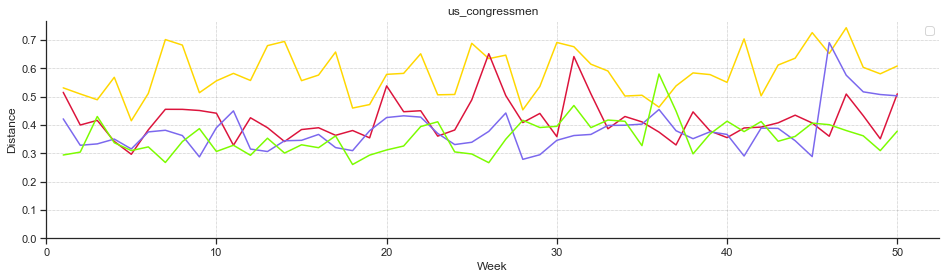

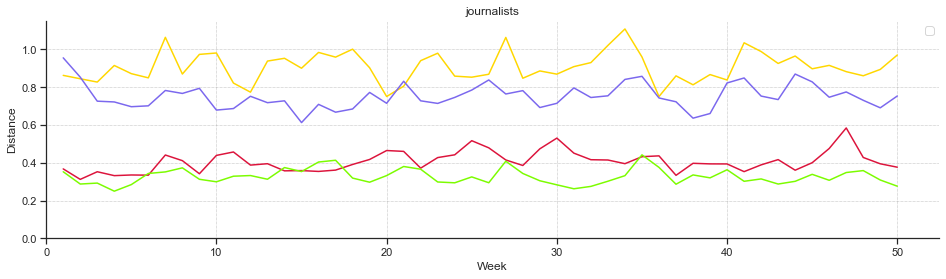

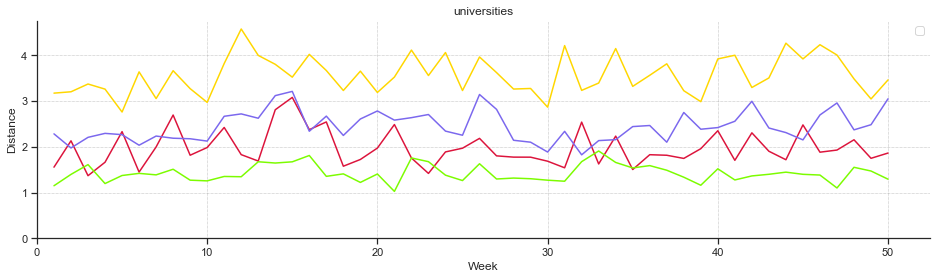

In [39]:
for net in networks:
    sns.set(rc={'figure.figsize':(16,4)})
    sns.set_style("ticks")
    ax = sns.lineplot(data= networks[net]["distances"], x= "To", y= "Distance", hue= "Emotion", palette=emotions)
    plt.xlim(0)
    plt.ylim(0)
    plt.xlabel("Week")
    plt.grid("both", linestyle="dotted", color="grey", linewidth=0.5)
    sns.despine()
    plt.title(net)
    plt.legend("")
    plt.show()

#### Distances per Network - Normalized

By being normalized, the propagation shows only the propagation proportionally among nodes.

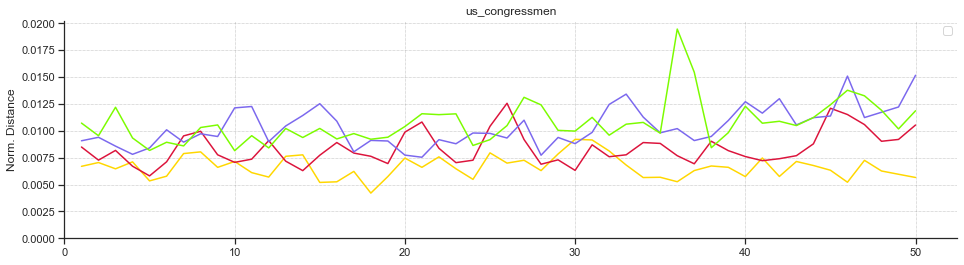

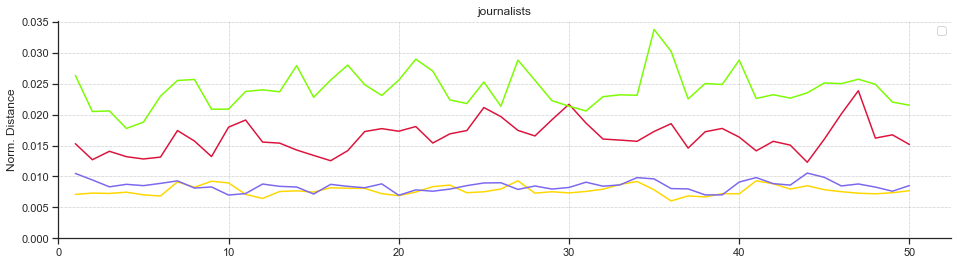

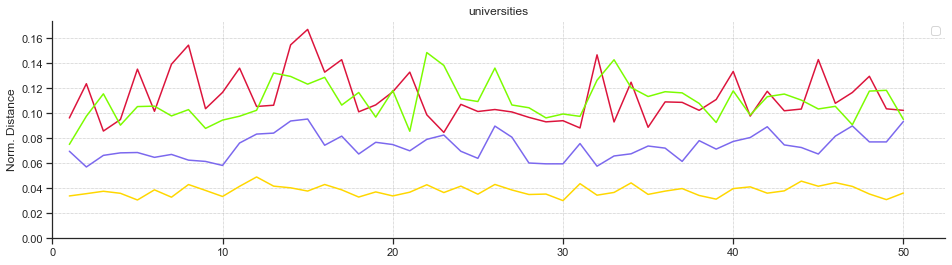

In [43]:
for net in networks.keys():
    sns.set(rc={'figure.figsize':(16,4)})
    sns.set_style("ticks")
    sns.lineplot(data= networks[net]["distances"], x= "To", y= "Norm. Distance", hue= "Emotion", palette=emotions)
    plt.xlim(0)
    plt.ylim(0)
    plt.legend("")
    plt.xlabel("")
    plt.grid("both", linestyle="dotted", color="grey", linewidth=0.5)
    sns.despine()
    plt.title(net)
    plt.show()

#### Propagation speed per network, avg. and std. for both Normalized and non-Normalized

In [44]:
for net in networks:
    print(f"NETWORK {net.upper()}")
    display(networks[net]["distances"].loc[:,["Emotion", "Distance", "Norm. Distance"]].groupby("Emotion").agg(["mean", "std"]).reset_index().\
            sort_values(("Norm. Distance", "std"), ascending = False))

NETWORK US_CONGRESSMEN


Emotion  Distance           Norm. Distance          
                 mean       std           mean       std
2  optimism  0.357247  0.060052       0.010693  0.001984
3   sadness  0.382043  0.077083       0.010352  0.001801
0     anger  0.420069  0.072126       0.008360  0.001515
1       joy  0.583199  0.080506       0.006616  0.001042

NETWORK JOURNALISTS


Emotion  Distance           Norm. Distance          
                 mean       std           mean       std
2  optimism  0.326914  0.041260       0.024119  0.003004
0     anger  0.407089  0.055059       0.016390  0.002481
3   sadness  0.752710  0.066024       0.008493  0.000837
1       joy  0.908335  0.079439       0.007740  0.000774

NETWORK UNIVERSITIES


Emotion  Distance           Norm. Distance          
                 mean       std           mean       std
0     anger  1.972698  0.383118       0.113266  0.019958
2  optimism  1.424252  0.189633       0.109625  0.015376
3   sadness  2.449307  0.334748       0.073430  0.010079
1       joy  3.569624  0.416244       0.037996  0.004257

#### Distance Scoreboard (top 10)

In [45]:
for net in networks:
    print(net.upper())
    display(networks[net]["distances"].sort_values(by = "Norm. Distance", ascending = False).head(10))

US_CONGRESSMEN


,Emotion,From,To,Distance,Norm. Distance
185,optimism,35,36,0.579893,0.019454
186,optimism,36,37,0.449493,0.015442
149,sadness,49,50,0.502939,0.015157
145,sadness,45,46,0.690757,0.015080
195,optimism,45,46,0.401101,0.013767
132,sadness,32,33,0.398383,0.013404
196,optimism,46,47,0.380413,0.013247
176,optimism,26,27,0.349928,0.013109
141,sadness,41,42,0.388971,0.012979
139,sadness,39,40,0.366670,0.012699


JOURNALISTS


,Emotion,From,To,Distance,Norm. Distance
184,optimism,34,35,0.441881,0.033791
185,optimism,35,36,0.375511,0.030245
170,optimism,20,21,0.380227,0.028985
189,optimism,39,40,0.362959,0.028826
176,optimism,26,27,0.408043,0.028824
166,optimism,16,17,0.413261,0.028020
163,optimism,13,14,0.374610,0.027934
171,optimism,21,22,0.365838,0.027046
150,optimism,0,1,0.352381,0.026354
196,optimism,46,47,0.348345,0.025733


UNIVERSITIES


,Emotion,From,To,Distance,Norm. Distance
64,anger,14,15,3.081805,0.167016
63,anger,13,14,2.811810,0.154661
57,anger,7,8,2.696318,0.154444
171,optimism,21,22,1.757401,0.148516
81,anger,31,32,2.541262,0.146692
94,anger,44,45,2.480720,0.142897
66,anger,16,17,2.545153,0.142812
182,optimism,32,33,1.909786,0.142741
56,anger,6,7,1.997703,0.139222
172,optimism,22,23,1.676201,0.138225


#### Emotion Acceleration (delta Speed)

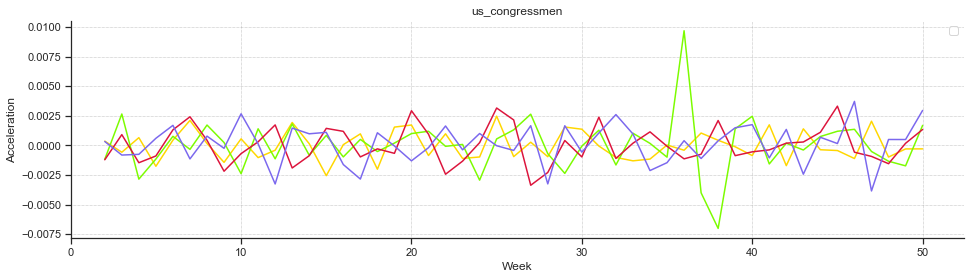

us_congressmen


,Emotion,From,To,Distance,Norm. Distance,change
185,optimism,35,36,0.579893,0.019454,0.009679
145,sadness,45,46,0.690757,0.015080,0.003711
94,anger,44,45,0.407077,0.012091,0.003308
74,anger,24,25,0.488438,0.010411,0.003151
149,sadness,49,50,0.502939,0.015157,0.002948
69,anger,19,20,0.537905,0.009871,0.002922
109,sadness,9,10,0.390455,0.012126,0.002662
152,optimism,2,3,0.430008,0.012184,0.002647
176,optimism,26,27,0.349928,0.013109,0.002630
131,sadness,31,32,0.366666,0.012445,0.002597


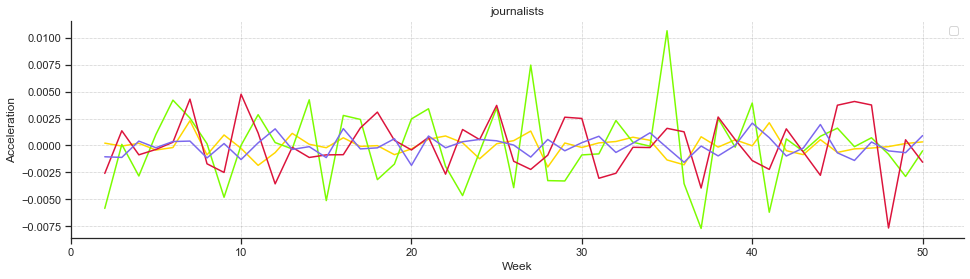

journalists


,Emotion,From,To,Distance,Norm. Distance,change
184,optimism,34,35,0.441881,0.033791,0.010648
176,optimism,26,27,0.408043,0.028824,0.007458
59,anger,9,10,0.438997,0.017978,0.004756
56,anger,6,7,0.441054,0.017432,0.004300
163,optimism,13,14,0.374610,0.027934,0.004237
155,optimism,5,6,0.343305,0.022994,0.004206
95,anger,45,46,0.475546,0.020119,0.004083
189,optimism,39,40,0.362959,0.028826,0.003941
96,anger,46,47,0.584281,0.023875,0.003755
94,anger,44,45,0.400236,0.016037,0.003735


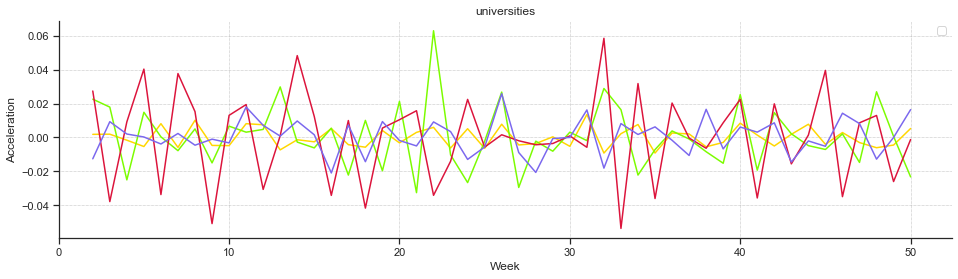

universities


,Emotion,From,To,Distance,Norm. Distance,change
171,optimism,21,22,1.757401,0.148516,0.062932
81,anger,31,32,2.541262,0.146692,0.058473
63,anger,13,14,2.811810,0.154661,0.048264
54,anger,4,5,2.332652,0.135254,0.040297
94,anger,44,45,2.480720,0.142897,0.039550
56,anger,6,7,1.997703,0.139222,0.037668
83,anger,33,34,2.235251,0.124795,0.031767
162,optimism,12,13,1.674109,0.132159,0.029805
181,optimism,31,32,1.676561,0.126373,0.028875
51,anger,1,2,2.132273,0.123601,0.027383


In [46]:
for net in networks:

    speed_changes = networks[net]["distances"].copy()
    dfs = []
    for e in emotions:
        _ = speed_changes.loc[speed_changes.Emotion == e]
        _["change"] = _["Norm. Distance"].diff()
        dfs.append(_)
    speed_changes = pd.concat(dfs)

    sns.set(rc={'figure.figsize':(16,4)})
    sns.set_style("ticks")
    ax = sns.lineplot(data= speed_changes, x= "To", y= "change", hue= "Emotion", palette=emotions)
    plt.xlim(0)
    plt.xlabel("Week")
    plt.ylabel("Acceleration")
    plt.legend("")
    plt.grid("both", linestyle="dotted", color="grey", linewidth=0.5)
    sns.despine()
    plt.title(net)
    plt.show()

    print(net)
    display(speed_changes.sort_values("change", ascending=False).head(10))

## Correlation between emotion presence and emotion variance against emotion propagation

### Emotion presence vs. Emotion Distance

We look at the correlation between the presence of emotions at the begining of the week and the propagation between that week and the next.

In [47]:
print("EMOTION PRESENCE AT T AND DISTANCE FROM T - T+1")

for net in networks:

    print(f"\nNetwork: {net.upper()}")

    for e in emotions:

        emo_vector = networks[net]["emotions-interpolated"].groupby("week").sum().reset_index().loc[:49,e]
        emo_distance = networks[net]["distances"][networks[net]["distances"].Emotion == e]["Distance"]
        corr, pvalue = pearsonr(emo_vector, emo_distance)

        print(f"{e.capitalize()}: {corr:.3f} - P-Value: {pvalue:.5f}")

EMOTION PRESENCE AT T AND DISTANCE FROM T - T+1

Network: US_CONGRESSMEN
Joy: 0.292 - P-Value: 0.03941
Optimism: 0.253 - P-Value: 0.07659
Anger: 0.065 - P-Value: 0.65212
Sadness: 0.266 - P-Value: 0.06145

Network: JOURNALISTS
Joy: -0.047 - P-Value: 0.74610
Optimism: 0.222 - P-Value: 0.12161
Anger: -0.137 - P-Value: 0.34124
Sadness: 0.122 - P-Value: 0.39841

Network: UNIVERSITIES
Joy: 0.172 - P-Value: 0.23223
Optimism: -0.026 - P-Value: 0.85822
Anger: 0.275 - P-Value: 0.05302
Sadness: 0.092 - P-Value: 0.52727


### Emotion variance vs. Emotion Distance

We look at the correlation between the variance of emotions from week to week and the propagation between those weeks.

In [48]:
print("EMOTION DISTANCE FROM T - T+1 AND ITS DISTANCE")

for net in networks:

    print(f"\nNetwork: {net.upper()}")

    for e in emotions:

        emo_diff = networks[net]["emotions-interpolated"].groupby("week").mean()[e].diff().dropna()
        emo_distance = networks[net]["distances"][networks[net]["distances"].Emotion == e]["Distance"]
        corr, pvalue = pearsonr(emo_diff, emo_distance)

        print(f"{e.capitalize()}: {corr:.3f} - P-Value: {pvalue:.5f}")

EMOTION DISTANCE FROM T - T+1 AND ITS DISTANCE

Network: US_CONGRESSMEN
Joy: -0.009 - P-Value: 0.95306
Optimism: 0.026 - P-Value: 0.85620
Anger: 0.222 - P-Value: 0.12122
Sadness: 0.208 - P-Value: 0.14638

Network: JOURNALISTS
Joy: 0.080 - P-Value: 0.58234
Optimism: -0.013 - P-Value: 0.92602
Anger: 0.055 - P-Value: 0.70684
Sadness: -0.000 - P-Value: 0.99802

Network: UNIVERSITIES
Joy: 0.099 - P-Value: 0.49186
Optimism: 0.194 - P-Value: 0.17618
Anger: -0.053 - P-Value: 0.71572
Sadness: -0.042 - P-Value: 0.77076


### Spearman correlation between week number and emotion presence

We wish to inspect if there is a general trend in emotion presence throughout the year.

In [49]:
threshold = 0.05 / 12

for net in networks:
    for e in emotions:
        c, p = pearsonr([i for i in range(51)], networks[net]["emotions-interpolated"].groupby("week").mean()[e])
        print(f"{net.upper()} - {e} - Statistic: {c:.3f}, p-value: {p:.5f} - {p < threshold}")
    print()

US_CONGRESSMEN - joy - Statistic: 0.366, p-value: 0.00832 - False
US_CONGRESSMEN - optimism - Statistic: 0.032, p-value: 0.82431 - False
US_CONGRESSMEN - anger - Statistic: -0.127, p-value: 0.37281 - False
US_CONGRESSMEN - sadness - Statistic: -0.107, p-value: 0.45340 - False

JOURNALISTS - joy - Statistic: 0.139, p-value: 0.33007 - False
JOURNALISTS - optimism - Statistic: -0.328, p-value: 0.01890 - False
JOURNALISTS - anger - Statistic: -0.044, p-value: 0.75821 - False
JOURNALISTS - sadness - Statistic: -0.020, p-value: 0.88726 - False

UNIVERSITIES - joy - Statistic: 0.401, p-value: 0.00355 - True
UNIVERSITIES - optimism - Statistic: -0.374, p-value: 0.00690 - False
UNIVERSITIES - anger - Statistic: 0.282, p-value: 0.04462 - False
UNIVERSITIES - sadness - Statistic: -0.215, p-value: 0.13055 - False



# Other Results & Resources

##### Avg. and Std. of speeds for each network - All weeks

In [50]:
for net in networks:
    print(net.upper())
    display(networks[net]["distances"][["Emotion", "Distance", "Norm. Distance"]].groupby("Emotion").mean())

US_CONGRESSMEN


,Distance,Norm. Distance
Emotion,,
anger,0.420069,0.008360
joy,0.583199,0.006616
optimism,0.357247,0.010693
sadness,0.382043,0.010352


JOURNALISTS


,Distance,Norm. Distance
Emotion,,
anger,0.407089,0.016390
joy,0.908335,0.007740
optimism,0.326914,0.024119
sadness,0.752710,0.008493


UNIVERSITIES


,Distance,Norm. Distance
Emotion,,
anger,1.972698,0.113266
joy,3.569624,0.037996
optimism,1.424252,0.109625
sadness,2.449307,0.073430


#### Example of propagation in small network:
- 5 Time steps
- 9 Nodes
- No edge weights

#### Examining the peaks

In [51]:
# Network to examine
net = "us_congressmen"
# Week to look at
# None if all period
w = None
# Emotion to look at
# None if all emotions
e = None

if w != None:
    begin= (pd.to_datetime("2022-01-01")) + timedelta(7*w)
    end = (pd.to_datetime("2022-01-01")) + timedelta(7*(w+1)-1)
else:
    begin = pd.to_datetime("2022-01-01")
    end = pd.to_datetime("2022-12-23")

print(f"We are looking at:\n{net.upper()}\n{e if e != None else 'All emotions'}\nEvents between {begin} and {end}")

We are looking at:
US_CONGRESSMEN
All emotions
Events between 2022-01-01 00:00:00 and 2022-12-23 00:00:00


#### Numbers for the peaks

In [52]:
if access_to_all:
    see_sub_grup_weekly_change(networks['universities']['sub_group'], 14, 'anger', 2, net = 'universities')
    see_sub_grup_weekly_change(networks['universities']['sub_group'], 32, 'anger', 2, net = 'universities')
    see_sub_grup_weekly_change(networks['us_congressmen']['sub_group'], 36, 'optimism', 3, net = 'us_congressmen')
    see_sub_grup_weekly_change(networks['journalists']['sub_group'], 35, 'optimism', 2, net = 'journalists')
    see_sub_grup_weekly_change(networks['journalists']['sub_group'], 35, 'optimism', 2, net = 'journalists')

In [53]:
def mean_change(odf, emotions):
    """Find the mean change across the network each day for each feeling."""
    df = odf.copy()
    df = df.sort_values(['author_id', 'week'])

    for emotion in emotions:

        df[emotion + '_change'] = df[emotion].diff().abs()

    return df[df.week != 0]


def absolute_change(net, emotion_order):
    """Find the absolute change across the network each day for each feeling."""
    overlap = [i % 51 != 0 for i in range(int(len(net)/4))][:-1]
    overlap[0] = True

    values = net.set_index(['author_id', 'emotion', 'week'])
    values.sort_index()


    moved = values.diff().abs().reset_index()
    moved = moved[moved['week'] != 50]
    final = moved.groupby(['emotion', 'week']).value.sum()
    final = final.reset_index()
    emotions = []
    for emotion in emotion_order:
        emotions.extend(final[final.emotion == emotion].value)

    return emotions

mean_change = mean_change(networks['us_congressmen']['emotions-interpolated'], list(emotions.keys()))
mean_changes = mean_change[list(emotions.keys()) + ['week']].groupby('week').mean()
print("The mean change for congressmen for week 36 is", mean_changes['optimism'][36])
print("The mean change for congressmen for all weeks is", mean_change['optimism'].mean())

The mean change for congressmen for week 36 is 0.08815154717543225
The mean change for congressmen for all weeks is 0.10071453291084316


### Test for inactivity in all networks

In [54]:
for net in networks.keys():
    no_tweets = networks[net]['emotions-aggregated'][networks[net]['emotions-aggregated'].weekly_tweet_values == 0]
    low_tweets = networks[net]['emotions-aggregated'][networks[net]['emotions-aggregated'].weekly_tweet_values < 4]
    print(f"{net} is inactive in {len(no_tweets) / len(networks[net]['emotions-aggregated']) * 100}% of weeks")
    print(f"{net} have low activity in {len(low_tweets) / len(networks[net]['emotions-aggregated']) * 100}% of weeks")


us_congressmen is inactive in 0.08194322505121451% of weeks
us_congressmen have low activity in 2.2066139888791336% of weeks
journalists is inactive in 0.25897151313355526% of weeks
journalists have low activity in 4.189789123196448% of weeks
universities is inactive in 0.21008403361344538% of weeks
universities have low activity in 4.427326486150015% of weeks
